# ERK-KTR Full FOV Stimulation Pipeline

## System Init

### Load pymmcore and required python libraries

In [1]:
import os

os.environ["QT_LOGGING_RULES"] = (
    "*.debug=false; *.warning=false"  # Fix to suppress PyQT warnings from napari-micromanager when running in a Jupyter notebook
)

from fov import FOV
from useq import MDAEvent
import pandas as pd
import numpy as np
import random
import napari
import pymmcore_plus
from napari_micromanager import MainWindow

from utils import create_folders
from useq._mda_event import SLMImage

mmc = pymmcore_plus.CMMCorePlus()

### Device Specific Init for Niesen Microscope

In [2]:
mmc.loadSystemConfiguration(
    "E:\\pertzlab_mic_configs\\micromanager\\Niesen\\Ti2CicercoConfig_w_DMD_w_TTL.cfg"
)

### The following libraries are used to wake up the Lumencor laser
import requests
import threading
import time


class WakeUpLaser:
    def __init__(self, lumencore_ip="192.168.201.200"):
        self.ip = lumencore_ip
        self.last_wakeup = 0
        self.is_running = False

    def wakeup_laser(self):
        url = f"http://{self.ip}/service/?command=WAKEUP"
        requests.get(url)

    def run(self, wait_for_warmup=False):
        self.is_running = True
        self.thread = threading.Thread(target=self._keep_alive)
        self.thread.start()
        if wait_for_warmup:
            time.sleep(15)

    def _keep_alive(self):
        while self.is_running:
            if time.time() - self.last_wakeup > 60:
                self.wakeup_laser()
                self.last_wakeup = time.time()
            time.sleep(3)

    def stop(self):
        self.is_running = False
        self.thread.join()


wl = WakeUpLaser()
wl.wakeup_laser()

slm_dev = mmc.getSLMDevice()
slm_width = mmc.getSLMWidth(slm_dev)
slm_height = mmc.getSLMHeight(slm_dev)

event_slm_on = MDAEvent(slm_image=SLMImage(data=True))
mmc.mda.run([event_slm_on])  # to only have fov of DMD
mmc.setROI(150, 150, 1900, 1900)

DMD_CHANNEL_GROUP = "WF_DMD"
DMD_CALIBRATION_PROFILE = {
    "channel_group": "WF_DMD",
    "channel_config": "CyanStim",
    "device_name": "LedDMD",
    "property_name": "Cyan_Level",
    "power": 100,
}
mmc.setChannelGroup(channelGroup=DMD_CHANNEL_GROUP)

[03/19/25 20:57:55] INFO     MDA Started: GeneratorMDASequence()                                     ]8;id=783228;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=815665;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#376\376]8;;\

                    INFO     slm_image=SLMImage()                                                    ]8;id=866608;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=664166;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\

                    INFO     MDA Finished: GeneratorMDASequence()                                    ]8;id=849179;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=253343;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#463\463]8;;\

## GUI - Napari Micromanager

### Load GUI

In [3]:
### Base GUI ###
viewer = napari.Viewer()
mm_wdg = MainWindow(viewer)
viewer.window.add_dock_widget(mm_wdg)

In [4]:
### Add MDA widget for FOV selection ###
from pymmcore_widgets.mda import MDAWidget

mdawidget = MDAWidget(mmcore=mmc)
viewer.window.add_dock_widget(mdawidget)

Error creating widget for Camera-1-PreampOffLimit: argument 1 overflowed: value must be in the range -2147483648 to 2147483647


### Functions to break and re-connect link with GUI if manually broken

The following functions can be used to manually interrupt to connection between the GUI and the running rtm-pymmcore script. However, normally you don't need to execute them. 

In [10]:
### Break connection
# mm_wdg._core_link.cleanup()

In [63]:
### Manually reconnect pymmcore with napari-micromanager
from napari_micromanager._core_link import CoreViewerLink

mm_wdg._core_link = CoreViewerLink(viewer, mmc)

## Create a DF with all planned acquisitions and stimulations

### Settings for Experiment

In [5]:
import pandas as pd
import os
from utils import create_folders
from fov import FOV
import numpy as np
import random

In [6]:
df_acquire = pd.DataFrame(
    columns=[
        "fov",
        "timestep",
        "time",
        "time_experiment",
        "treatment",
        "acquired",
        "stim",
        "channels",
        "channel_stim",
    ]
)

base_path = "\\\\izbkingston.unibe.ch\\imaging.data\\mic01-imaging\\Alex\\pymmcore\\"
experiment_name = "2025-03-19_optoTIAM_migration_percentage_Niesen_miRFP_mcherry"
path = os.path.join(base_path, experiment_name)

create_folders(
    path, ["stim", "raw", "labels", "stim_mask", "tracks", "labels_rings", "particles"]
)

time_between_frames = 10  # time in seconds between frames
time_per_fov = 5  # time in seconds per fov

N_TIMESTEPS = 60 // time_between_frames * 20

timesteps = range(N_TIMESTEPS)
channels = ["Red", "Green"]  # channel for segmentation first
channels_exposure = [100, 100]

# take values from UI, if loaded
intensity_red_laser = mmc.getProperty("Laser", "RED_Intensity")
intensity_green_laser = mmc.getProperty("Laser", "GREEN_Intensity")

if intensity_red_laser != str(0) and intensity_green_laser != str(0):
    channels_power = [intensity_red_laser, intensity_green_laser]
else:
    channels_power = [80, 80]
    for channel, power in zip(channels, channels_power):
        mmc.setProperty("Laser", f"{channel.upper()}_Intensity", power)


stim_exposures = [100]  # list of possible exposures in ms
stim_timesteps = [
    list(range(0, 15))
]  # list of timesteps for stimulation, if e.g. double stimulation in frame 0 and 1 is needed write [[0,1]]
stim_percentages = [0.2, 0.3]
stim_profiles = [
    {
        "device_name": "LedDMD",
        "property_name": "Cyan_Level",
        "power": 10,
        "channel": "CyanStim",
    }
]
stim_treatments = [
    {
        "stim_profile": stim_profile,
        "stim_exposure": stim_exposure,
        "stim_timestep": stim_timestep,
        "stim_cell_percentage": stim_cell_percentage,
    }
    for stim_profile in stim_profiles
    for stim_exposure in stim_exposures
    for stim_timestep in stim_timesteps
    for stim_cell_percentage in stim_percentages
]
cell_lines = ["miRFP", "mCherry"]
n_fovs_per_cell_line = 12
data_mda_fovs = None
stim_treatments

Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-19_optoTIAM_migration_percentage_Niesen_miRFP_mcherry\stim created 
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-19_optoTIAM_migration_percentage_Niesen_miRFP_mcherry\raw created 
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-19_optoTIAM_migration_percentage_Niesen_miRFP_mcherry\labels created 
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-19_optoTIAM_migration_percentage_Niesen_miRFP_mcherry\stim_mask created 
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-19_optoTIAM_migration_percentage_Niesen_miRFP_mcherry\tracks created 
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-19_optoTIAM_migration_percentage_Niesen_miRFP_mcherry\labels_rings created 
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-19

[{'stim_profile': {'device_name': 'LedDMD',
   'property_name': 'Cyan_Level',
   'power': 10,
   'channel': 'CyanStim'},
  'stim_exposure': 100,
  'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  'stim_cell_percentage': 0.2},
 {'stim_profile': {'device_name': 'LedDMD',
   'property_name': 'Cyan_Level',
   'power': 10,
   'channel': 'CyanStim'},
  'stim_exposure': 100,
  'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  'stim_cell_percentage': 0.3}]

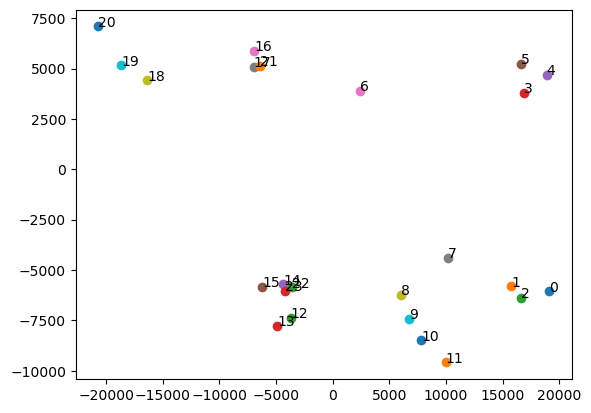

In [7]:
import matplotlib.pyplot as plt

plt.figure()
data_mda_fovs = mdawidget.value().stage_positions
i = 0
for fov_x_y in data_mda_fovs:
    plt.scatter(fov_x_y.x, fov_x_y.y, label=f"{fov_x_y.x},{fov_x_y.y}")
    plt.text(fov_x_y.x, fov_x_y.y, f"{i}")
    i += 1
plt.show()

### Map Experiment to FOVs

#### If FOVs already saved - Reload them from file

In [29]:
import json

# file = os.path.join(path, "fovs.json")
file = "fovs.json"
with open(file, "r") as f:
    data_mda_fovs = json.load(f)

Only select one of the following two code blocks. If you autogenerated FOVs using the wellplate option of the MDA widget, then use the first code block, else the second. 

#### MDA Widget was used in wellplate mode with autogenerated FOVs

#### FOVs were manually selected using MDA widget

In [8]:
fovs: list[FOV] = []
if data_mda_fovs is None:
    data_mda_fovs = mdawidget.value().stage_positions
n_fovs = len(data_mda_fovs)
n_stim_treatments = len(stim_treatments)
n_fovs_per_stim_condition = n_fovs // len(np.unique(cell_lines))

j = 0
for stim_treatment in stim_treatments:
    for i, row in enumerate(data_mda_fovs):
        row = dict(row)
        if len(cell_lines) == 1:
            cell_line = cell_lines[0]
        else:
            cell_line = cell_lines[i // n_fovs_per_cell_line]
        fov = FOV(
            pos=(row["x"], row["y"]),
            index=j,
            name=str(i),
            path=path,
            metadata={"cell_line": cell_line},
            treatment=stim_treatment,
        )
        fovs.append(fov)
        j += 1

### Use FOVs to generate dataframe for acquisition

In [10]:
n_fovs_simultaneously = time_between_frames // time_per_fov
start_time = 0

dfs = []
for fov in fovs:
    fov_group = fov.index // n_fovs_simultaneously
    start_time = fov_group * time_between_frames * len(timesteps)

    for timestep in timesteps:
        if fov.metadata["cell_line"] == "mCherry":
            channels_power = [80]
            channels = ["Green"]
            channels_exposure = [100]
        if fov.metadata["cell_line"] == "miRFP":
            channels_power = [80]
            channels = ["Red"]
            channels_exposure = [100]

        new_row = {
            "fov_object": fov,
            "fov": fov.index,
            "name": fov.name,
            "timestep": timestep,
            "time": start_time + timestep * time_between_frames,
            "treatment": fov.treatment,
            "metadata": fov.metadata,
            "stim": timestep in fov.treatment["stim_timestep"]
            and fov.treatment["stim_exposure"]
            != 0,  # not really important, only for visualisation
            "channels": channels,
            "channels_exposure": channels_exposure,
            "channel_power": channels_power,
            "fname": f"{str(fov.index).zfill(3)}_{str(timestep).zfill(5)}",
        }
        dfs.append(new_row)

df_acquire = pd.DataFrame(dfs)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", True)
df_acquire = df_acquire.sort_values(by=["time", "fov"])
print(f"Total Experiment Time: {df_acquire['time'].max()/3600}h")
df_acquire

Total Experiment Time: 7.997222222222222h


fov_object  fov name  timestep   time  \
0     <fov.FOV object at 0x000001E00F693BE0>    0    0         0      0   
120   <fov.FOV object at 0x000001E00F6934C0>    1    1         0      0   
1     <fov.FOV object at 0x000001E00F693BE0>    0    0         1     10   
121   <fov.FOV object at 0x000001E00F6934C0>    1    1         1     10   
2     <fov.FOV object at 0x000001E00F693BE0>    0    0         2     20   
...                                      ...  ...  ...       ...    ...   
5757  <fov.FOV object at 0x000001E00F6452A0>   47   23       117  28770   
5638  <fov.FOV object at 0x000001E00F645270>   46   22       118  28780   
5758  <fov.FOV object at 0x000001E00F6452A0>   47   23       118  28780   
5639  <fov.FOV object at 0x000001E00F645270>   46   22       119  28790   
5759  <fov.FOV object at 0x000001E00F6452A0>   47   23       119  28790   

                                              treatment  \
0     {'stim_profile': {'device_name': 'LedDMD', 'pr...   
120   {'stim_profile': {'device_name': 'LedDMD', 'pr...   
1     {'stim_profile': {'device_name': 'LedDMD', 'pr...   
121   {'stim_profile': {'device_name': 'LedDMD', 'pr...   
2     {'stim_profile': {'device_name': 'LedDMD', 'pr...   
...                                                 ...   
5757  {'stim_profile': {'device_name': 'LedDMD', 'pr...   
5638  {'stim_profile': {'device_name': 'LedDMD', 'pr...   
5758  {'stim_profile': {'device_name': 'LedDMD', 'pr...   
5639  {'stim_profile': {'device_name': 'LedDMD', 'pr...   
5759  {'stim_profile': {'device_name': 'LedDMD', 'pr...   

                      metadata   stim channels channels_exposure  \
0       {'cell_line': 'miRFP'}   True    [Red]             [100]   
120     {'cell_line': 'miRFP'}   True    [Red]             [100]   
1       {'cell_line': 'miRFP'}   True    [Red]             [100]   
121     {'cell_line': 'miRFP'}   True    [Red]             [100]   
2       {'cell_line': 'miRFP'}   True    [Red]             [100]   
...                        ...    ...      ...               ...   
5757  {'cell_line': 'mCherry'}  False  [Green]             [100]   
5638  {'cell_line': 'mCherry'}  False  [Green]             [100]   
5758  {'cell_line': 'mCherry'}  False  [Green]             [100]   
5639  {'cell_line': 'mCherry'}  False  [Green]             [100]   
5759  {'cell_line': 'mCherry'}  False  [Green]             [100]   

     channel_power      fname  
0             [80]  000_00000  
120           [80]  001_00000  
1             [80]  000_00001  
121           [80]  001_00001  
2             [80]  000_00002  
...            ...        ...  
5757          [80]  047_00117  
5638          [80]  046_00118  
5758          [80]  047_00118  
5639          [80]  046_00119  
5759          [80]  047_00119  

[5760 rows x 12 columns]

In [21]:
df_acquire_test = df_acquire.copy()
df_acquire_test = df_acquire_test.query("fov < 2 and timestep < 3")

In [22]:
df_acquire_test

fov_object  fov name  timestep  time  \
0    <fov.FOV object at 0x000001E00F693BE0>    0    0         0     0   
120  <fov.FOV object at 0x000001E00F6934C0>    1    1         0     0   
1    <fov.FOV object at 0x000001E00F693BE0>    0    0         1    10   
121  <fov.FOV object at 0x000001E00F6934C0>    1    1         1    10   
2    <fov.FOV object at 0x000001E00F693BE0>    0    0         2    20   
122  <fov.FOV object at 0x000001E00F6934C0>    1    1         2    20   

                                             treatment  \
0    {'stim_profile': {'device_name': 'LedDMD', 'pr...   
120  {'stim_profile': {'device_name': 'LedDMD', 'pr...   
1    {'stim_profile': {'device_name': 'LedDMD', 'pr...   
121  {'stim_profile': {'device_name': 'LedDMD', 'pr...   
2    {'stim_profile': {'device_name': 'LedDMD', 'pr...   
122  {'stim_profile': {'device_name': 'LedDMD', 'pr...   

                   metadata  stim channels channels_exposure channel_power  \
0    {'cell_line': 'miRFP'}  True    [Red]             [100]          [80]   
120  {'cell_line': 'miRFP'}  True    [Red]             [100]          [80]   
1    {'cell_line': 'miRFP'}  True    [Red]             [100]          [80]   
121  {'cell_line': 'miRFP'}  True    [Red]             [100]          [80]   
2    {'cell_line': 'miRFP'}  True    [Red]             [100]          [80]   
122  {'cell_line': 'miRFP'}  True    [Red]             [100]          [80]   

         fname  
0    000_00000  
120  001_00000  
1    000_00001  
121  001_00001  
2    000_00002  
122  001_00002

## Run experiment

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
from dmd import DMD

affine_matrix = np.load("affine_matrix.npy")
dmd = DMD(mmc, DMD_CALIBRATION_PROFILE, affine_matrix)
# events = dmd.calibrate(verbous=True)

In [72]:
# np.save("affine_matrix.npy", dmd.affine)

In [ ]:
%load_ext autoreload
%autoreload 2
from add_frame import ImageProcessingPipeline
from segmentation.imaging_server import SegmentatorImagingServerKit
from stimulation.percentage_of_cell import StimPercentageOfCell
from controller import Controller, Analyzer
from tracking.trackpy import TrackerTrackpy
from queue import Queue

try:
    mm_wdg._core_link.cleanup()
except:
    pass

segmentator = SegmentatorImagingServerKit(
    "http://localhost:8020",
    "cellpose",
    {
        "model_name": "cyto3",
        "diameter": 75,
        "flow_threshold": 0.4,
    },
)
stimulator = StimPercentageOfCell()
tracker = TrackerTrackpy()

pipeline = ImageProcessingPipeline(segmentator, stimulator, tracker)
analyzer = Analyzer(pipeline)
queue = Queue()
controller = Controller(analyzer, mmc, queue, dmd)
# wl.run(wait_for_warmup=True)
controller.run(df_acquire)
# wl.stop()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[19/03/2025 21:50:56] INFO     MDA Started: GeneratorMDASequence()                                   ]8;id=678268;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=405707;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#376\376]8;;\

                      INFO     index={'t': 0, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=738428;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=580875;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=0.0 x_pos=19109.1                     
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 0, 'time': 0,               
                               'treatment': {'stim_profile': {'device_name': 'LedDMD',                             
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00000', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:01] INFO     index={'t': 0, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=702070;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=226380;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=0.0 x_pos=19109.1                     
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 0, 'time': 0, 'treatment':                       
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00000', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

                      INFO     index={'t': 0, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=997162;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=808145;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=0.0 x_pos=15782.3                     
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 0, 'time': 0,               
                               'treatment': {'stim_profile': {'device_name': 'LedDMD',                             
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00000', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:04] INFO     index={'t': 0, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=52550;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=302170;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=0.0 x_pos=15782.3                     
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 0, 'time': 0, 'treatment':                       
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00000', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:06] INFO     index={'t': 1, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=467431;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=648023;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=10.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 1, 'time':                  
                               10, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00001', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:09] INFO     index={'t': 1, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=803027;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=820144;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=10.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 1, 'time': 10, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00001', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:10] INFO     index={'t': 1, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=206952;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=635112;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=10.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 1, 'time':                  
                               10, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00001', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:12] INFO     index={'t': 1, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=940985;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=939918;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=10.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 1, 'time': 10, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00001', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:16] INFO     index={'t': 2, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=159040;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=814176;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=20.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 2, 'time':                  
                               20, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00002', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:19] INFO     index={'t': 2, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=191574;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=544069;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=20.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 2, 'time': 20, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00002', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:20] INFO     index={'t': 2, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=178129;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=151758;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=20.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 2, 'time':                  
                               20, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00002', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:22] INFO     index={'t': 2, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=767765;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=401236;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=20.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 2, 'time': 20, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00002', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:26] INFO     index={'t': 3, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=144059;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=761139;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=30.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 3, 'time':                  
                               30, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00003', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:29] INFO     index={'t': 3, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=880079;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=791726;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=30.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 3, 'time': 30, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00003', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:30] INFO     index={'t': 3, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=985414;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=496364;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=30.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 3, 'time':                  
                               30, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00003', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:32] INFO     index={'t': 3, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=651753;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=759447;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=30.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 3, 'time': 30, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00003', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:36] INFO     index={'t': 4, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=337034;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=843567;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=40.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 4, 'time':                  
                               40, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00004', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:39] INFO     index={'t': 4, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=817973;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=210003;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=40.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 4, 'time': 40, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00004', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:40] INFO     index={'t': 4, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=23721;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=690724;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=40.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 4, 'time':                  
                               40, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00004', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:42] INFO     index={'t': 4, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=653312;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=658128;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=40.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 4, 'time': 40, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00004', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:46] INFO     index={'t': 5, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=571660;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=981611;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=50.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 5, 'time':                  
                               50, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00005', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:49] INFO     index={'t': 5, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=878134;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=942689;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=50.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 5, 'time': 50, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00005', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:50] INFO     index={'t': 5, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=940912;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=211494;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=50.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 5, 'time':                  
                               50, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00005', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:52] INFO     index={'t': 5, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=131983;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=758607;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=50.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 5, 'time': 50, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00005', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:51:56] INFO     index={'t': 6, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=656900;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=723718;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=60.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 6, 'time':                  
                               60, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00006', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:51:59] INFO     index={'t': 6, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=790460;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=760086;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=60.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 6, 'time': 60, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00006', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:00] INFO     index={'t': 6, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=387016;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=13780;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=60.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 6, 'time':                  
                               60, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00006', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:02] INFO     index={'t': 6, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=987191;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=454688;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=60.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 6, 'time': 60, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00006', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:06] INFO     index={'t': 7, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=906457;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=115411;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=70.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 7, 'time':                  
                               70, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00007', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:09] INFO     index={'t': 7, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=859001;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=666707;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=70.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 7, 'time': 70, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00007', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:10] INFO     index={'t': 7, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=656560;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=811322;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=70.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 7, 'time':                  
                               70, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00007', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:12] INFO     index={'t': 7, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=758417;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=304613;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=70.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 7, 'time': 70, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00007', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:16] INFO     index={'t': 8, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=658801;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=320391;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=80.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 8, 'time':                  
                               80, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00008', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:19] INFO     index={'t': 8, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=611354;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=765645;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=80.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 8, 'time': 80, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00008', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:20] INFO     index={'t': 8, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=644469;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=417855;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=80.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 8, 'time':                  
                               80, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00008', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:22] INFO     index={'t': 8, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=582696;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=998983;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=80.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 8, 'time': 80, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00008', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:26] INFO     index={'t': 9, 'c': 0, 'p': 0} channel=Channel(config='Red',          ]8;id=353210;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=942632;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=90.0 x_pos=19109.1                    
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 9, 'time':                  
                               90, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00009', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:29] INFO     index={'t': 9, 'p': 0} channel=Channel(config='CyanStim',             ]8;id=631431;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=181697;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=90.0 x_pos=19109.1                    
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 9, 'time': 90, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00009', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:30] INFO     index={'t': 9, 'c': 0, 'p': 1} channel=Channel(config='Red',          ]8;id=691081;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=311552;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=90.0 x_pos=15782.3                    
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 9, 'time':                  
                               90, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                         
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00009', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:32] INFO     index={'t': 9, 'p': 1} channel=Channel(config='CyanStim',             ]8;id=486485;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=219459;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=90.0 x_pos=15782.3                    
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 9, 'time': 90, 'treatment':                      
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00009', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:36] INFO     index={'t': 10, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=593427;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=683696;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=100.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 10, 'time':                 
                               100, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00010', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:39] INFO     index={'t': 10, 'p': 0} channel=Channel(config='CyanStim',            ]8;id=982350;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=856315;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=100.0 x_pos=19109.1                   
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 10, 'time': 100, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00010', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:40] INFO     index={'t': 10, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=51345;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=773899;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=100.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 10, 'time':                 
                               100, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00010', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:42] INFO     index={'t': 10, 'p': 1} channel=Channel(config='CyanStim',            ]8;id=587151;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=320244;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=100.0 x_pos=15782.3                   
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 10, 'time': 100, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00010', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:46] INFO     index={'t': 11, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=747160;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=313125;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=110.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 11, 'time':                 
                               110, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00011', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:49] INFO     index={'t': 11, 'p': 0} channel=Channel(config='CyanStim',            ]8;id=498258;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=789360;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=110.0 x_pos=19109.1                   
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 11, 'time': 110, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00011', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:50] INFO     index={'t': 11, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=203993;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=279159;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=110.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 11, 'time':                 
                               110, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00011', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:52] INFO     index={'t': 11, 'p': 1} channel=Channel(config='CyanStim',            ]8;id=812541;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=242320;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=110.0 x_pos=15782.3                   
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 11, 'time': 110, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00011', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:52:56] INFO     index={'t': 12, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=428370;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=467073;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=120.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 12, 'time':                 
                               120, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00012', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:52:59] INFO     index={'t': 12, 'p': 0} channel=Channel(config='CyanStim',            ]8;id=479585;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=792889;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=120.0 x_pos=19109.1                   
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 12, 'time': 120, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00012', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:53:00] INFO     index={'t': 12, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=359479;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=73864;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=120.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 12, 'time':                 
                               120, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00012', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:02] INFO     index={'t': 12, 'p': 1} channel=Channel(config='CyanStim',            ]8;id=982893;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=694504;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=120.0 x_pos=15782.3                   
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 12, 'time': 120, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00012', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:53:06] INFO     index={'t': 13, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=562478;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=208654;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=130.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 13, 'time':                 
                               130, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00013', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:09] INFO     index={'t': 13, 'p': 0} channel=Channel(config='CyanStim',            ]8;id=254627;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=863459;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=130.0 x_pos=19109.1                   
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 13, 'time': 130, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00013', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:53:10] INFO     index={'t': 13, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=942142;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=674491;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=130.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 13, 'time':                 
                               130, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00013', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:12] INFO     index={'t': 13, 'p': 1} channel=Channel(config='CyanStim',            ]8;id=319251;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=961209;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=130.0 x_pos=15782.3                   
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 13, 'time': 130, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00013', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:53:16] INFO     index={'t': 14, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=250207;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=530076;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=140.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 14, 'time':                 
                               140, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00014', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:19] INFO     index={'t': 14, 'p': 0} channel=Channel(config='CyanStim',            ]8;id=265992;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=267766;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=140.0 x_pos=19109.1                   
                               y_pos=-6058.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BE0>,                     
                               'fov': 0, 'name': '0', 'timestep': 14, 'time': 140, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '000_00014', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:53:20] INFO     index={'t': 14, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=580083;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=686301;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=140.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 14, 'time':                 
                               140, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00014', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:22] INFO     index={'t': 14, 'p': 1} channel=Channel(config='CyanStim',            ]8;id=552722;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=691390;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=140.0 x_pos=15782.3                   
                               y_pos=-5815.0 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F6934C0>,                     
                               'fov': 1, 'name': '1', 'timestep': 14, 'time': 140, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '001_00014', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 21:53:26] INFO     index={'t': 15, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=95734;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=893034;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=150.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 15, 'time':                 
                               150, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00015', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:27] INFO     index={'t': 15, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=816196;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=619545;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=150.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 15, 'time':                 
                               150, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00015', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:36] INFO     index={'t': 16, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=378259;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=357242;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=160.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 16, 'time':                 
                               160, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00016', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:37] INFO     index={'t': 16, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=293171;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=342408;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=160.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 16, 'time':                 
                               160, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00016', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:46] INFO     index={'t': 17, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=121494;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=226117;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=170.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 17, 'time':                 
                               170, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00017', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:47] INFO     index={'t': 17, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=215148;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=400442;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=170.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 17, 'time':                 
                               170, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00017', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:56] INFO     index={'t': 18, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=137540;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=424301;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=180.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 18, 'time':                 
                               180, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00018', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:53:57] INFO     index={'t': 18, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=57572;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=757488;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=180.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 18, 'time':                 
                               180, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00018', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:06] INFO     index={'t': 19, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=812661;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=803998;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=190.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 19, 'time':                 
                               190, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00019', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:07] INFO     index={'t': 19, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=487707;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=177517;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=190.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 19, 'time':                 
                               190, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00019', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:16] INFO     index={'t': 20, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=458174;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=125862;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=200.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 20, 'time':                 
                               200, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00020', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:17] INFO     index={'t': 20, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=577337;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=734285;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=200.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 20, 'time':                 
                               200, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00020', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:26] INFO     index={'t': 21, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=452748;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=675275;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=210.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 21, 'time':                 
                               210, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00021', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:27] INFO     index={'t': 21, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=788236;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=58000;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=210.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 21, 'time':                 
                               210, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00021', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:36] INFO     index={'t': 22, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=85668;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=923989;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=220.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 22, 'time':                 
                               220, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00022', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:37] INFO     index={'t': 22, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=428289;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=987370;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=220.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 22, 'time':                 
                               220, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00022', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:46] INFO     index={'t': 23, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=817341;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=420138;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=230.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 23, 'time':                 
                               230, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00023', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:47] INFO     index={'t': 23, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=24280;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=564478;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=230.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 23, 'time':                 
                               230, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00023', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:56] INFO     index={'t': 24, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=820323;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=459962;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=240.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 24, 'time':                 
                               240, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00024', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:54:57] INFO     index={'t': 24, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=495775;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=698601;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=240.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 24, 'time':                 
                               240, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00024', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:06] INFO     index={'t': 25, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=718879;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=680693;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=250.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 25, 'time':                 
                               250, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00025', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:07] INFO     index={'t': 25, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=163047;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=411539;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=250.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 25, 'time':                 
                               250, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00025', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:16] INFO     index={'t': 26, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=638337;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=756004;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=260.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 26, 'time':                 
                               260, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00026', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:17] INFO     index={'t': 26, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=24224;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=818227;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=260.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 26, 'time':                 
                               260, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00026', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:26] INFO     index={'t': 27, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=486533;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=432840;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=270.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 27, 'time':                 
                               270, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00027', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:27] INFO     index={'t': 27, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=305033;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=160520;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=270.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 27, 'time':                 
                               270, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00027', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:36] INFO     index={'t': 28, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=402754;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=77830;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=280.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 28, 'time':                 
                               280, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00028', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:37] INFO     index={'t': 28, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=868877;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=221569;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=280.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 28, 'time':                 
                               280, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00028', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:46] INFO     index={'t': 29, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=680672;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=782208;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=290.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 29, 'time':                 
                               290, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00029', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:47] INFO     index={'t': 29, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=672291;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=710610;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=290.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 29, 'time':                 
                               290, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00029', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:56] INFO     index={'t': 30, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=545050;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=220982;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=300.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 30, 'time':                 
                               300, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00030', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:55:57] INFO     index={'t': 30, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=671689;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=947634;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=300.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 30, 'time':                 
                               300, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00030', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:06] INFO     index={'t': 31, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=727537;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=667112;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=310.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 31, 'time':                 
                               310, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00031', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:07] INFO     index={'t': 31, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=744253;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=627295;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=310.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 31, 'time':                 
                               310, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00031', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:16] INFO     index={'t': 32, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=839635;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=57878;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=320.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 32, 'time':                 
                               320, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00032', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:17] INFO     index={'t': 32, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=481201;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=769294;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=320.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 32, 'time':                 
                               320, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00032', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:26] INFO     index={'t': 33, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=479767;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=964439;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=330.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 33, 'time':                 
                               330, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00033', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:27] INFO     index={'t': 33, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=16265;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=351761;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=330.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 33, 'time':                 
                               330, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00033', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:36] INFO     index={'t': 34, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=109312;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=86715;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=340.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 34, 'time':                 
                               340, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00034', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:37] INFO     index={'t': 34, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=458073;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=967804;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=340.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 34, 'time':                 
                               340, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00034', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:46] INFO     index={'t': 35, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=370966;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=90998;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=350.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 35, 'time':                 
                               350, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00035', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:47] INFO     index={'t': 35, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=256879;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=462405;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=350.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 35, 'time':                 
                               350, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00035', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:56] INFO     index={'t': 36, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=433599;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=141406;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=360.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 36, 'time':                 
                               360, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00036', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:56:57] INFO     index={'t': 36, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=391693;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=629017;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=360.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 36, 'time':                 
                               360, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00036', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:06] INFO     index={'t': 37, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=96634;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=936694;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=370.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 37, 'time':                 
                               370, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00037', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:07] INFO     index={'t': 37, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=647480;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=110600;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=370.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 37, 'time':                 
                               370, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00037', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:16] INFO     index={'t': 38, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=214867;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=760635;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=380.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 38, 'time':                 
                               380, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00038', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:17] INFO     index={'t': 38, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=734045;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=652704;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=380.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 38, 'time':                 
                               380, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00038', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:26] INFO     index={'t': 39, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=761151;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=56329;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=390.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 39, 'time':                 
                               390, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00039', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:27] INFO     index={'t': 39, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=610172;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=389561;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=390.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 39, 'time':                 
                               390, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00039', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:36] INFO     index={'t': 40, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=341726;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=480758;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=400.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 40, 'time':                 
                               400, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00040', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:37] INFO     index={'t': 40, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=862863;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=878626;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=400.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 40, 'time':                 
                               400, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00040', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:46] INFO     index={'t': 41, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=152485;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=529262;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=410.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 41, 'time':                 
                               410, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00041', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:47] INFO     index={'t': 41, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=821174;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=407775;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=410.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 41, 'time':                 
                               410, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00041', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:56] INFO     index={'t': 42, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=920623;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=885093;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=420.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 42, 'time':                 
                               420, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00042', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:57:57] INFO     index={'t': 42, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=35800;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=920469;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=420.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 42, 'time':                 
                               420, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00042', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:06] INFO     index={'t': 43, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=615143;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=761285;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=430.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 43, 'time':                 
                               430, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00043', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:07] INFO     index={'t': 43, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=985049;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=412847;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=430.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 43, 'time':                 
                               430, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00043', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:16] INFO     index={'t': 44, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=645188;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=658992;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=440.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 44, 'time':                 
                               440, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00044', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:17] INFO     index={'t': 44, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=241786;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=771792;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=440.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 44, 'time':                 
                               440, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00044', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:26] INFO     index={'t': 45, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=417228;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=177149;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=450.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 45, 'time':                 
                               450, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00045', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:27] INFO     index={'t': 45, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=983434;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=171221;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=450.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 45, 'time':                 
                               450, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00045', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:36] INFO     index={'t': 46, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=489071;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=598177;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=460.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 46, 'time':                 
                               460, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00046', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:37] INFO     index={'t': 46, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=55095;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=610322;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=460.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 46, 'time':                 
                               460, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00046', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:46] INFO     index={'t': 47, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=397859;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=727739;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=470.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 47, 'time':                 
                               470, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00047', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:47] INFO     index={'t': 47, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=615033;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=952119;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=470.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 47, 'time':                 
                               470, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00047', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:56] INFO     index={'t': 48, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=759875;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=695033;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=480.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 48, 'time':                 
                               480, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00048', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:58:57] INFO     index={'t': 48, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=591205;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=63863;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=480.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 48, 'time':                 
                               480, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00048', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:06] INFO     index={'t': 49, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=36472;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=302261;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=490.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 49, 'time':                 
                               490, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00049', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:07] INFO     index={'t': 49, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=673783;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=669327;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=490.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 49, 'time':                 
                               490, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00049', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:16] INFO     index={'t': 50, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=709335;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=981152;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=500.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 50, 'time':                 
                               500, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00050', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:17] INFO     index={'t': 50, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=508491;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=463793;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=500.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 50, 'time':                 
                               500, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00050', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:26] INFO     index={'t': 51, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=885982;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=825756;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=510.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 51, 'time':                 
                               510, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00051', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:27] INFO     index={'t': 51, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=768853;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=142670;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=510.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 51, 'time':                 
                               510, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00051', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:36] INFO     index={'t': 52, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=363832;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=299210;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=520.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 52, 'time':                 
                               520, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00052', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:37] INFO     index={'t': 52, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=786440;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=590203;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=520.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 52, 'time':                 
                               520, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00052', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:46] INFO     index={'t': 53, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=52029;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=726948;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=530.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 53, 'time':                 
                               530, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00053', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:47] INFO     index={'t': 53, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=806157;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=212438;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=530.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 53, 'time':                 
                               530, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00053', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:56] INFO     index={'t': 54, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=1974;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=77487;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=540.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 54, 'time':                 
                               540, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00054', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 21:59:57] INFO     index={'t': 54, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=791241;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=82584;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=540.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 54, 'time':                 
                               540, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00054', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:06] INFO     index={'t': 55, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=679208;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=694534;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=550.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 55, 'time':                 
                               550, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00055', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:07] INFO     index={'t': 55, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=270638;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=727431;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=550.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 55, 'time':                 
                               550, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00055', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:16] INFO     index={'t': 56, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=929568;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=141080;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=560.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 56, 'time':                 
                               560, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00056', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:17] INFO     index={'t': 56, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=119764;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=590293;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=560.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 56, 'time':                 
                               560, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00056', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:26] INFO     index={'t': 57, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=702181;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=892138;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=570.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 57, 'time':                 
                               570, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00057', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:27] INFO     index={'t': 57, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=9956;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=644811;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=570.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 57, 'time':                 
                               570, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00057', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:36] INFO     index={'t': 58, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=864312;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=988568;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=580.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 58, 'time':                 
                               580, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00058', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:37] INFO     index={'t': 58, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=125658;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=881555;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=580.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 58, 'time':                 
                               580, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00058', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:46] INFO     index={'t': 59, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=194645;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=287044;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=590.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 59, 'time':                 
                               590, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00059', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:47] INFO     index={'t': 59, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=976477;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=194493;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=590.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 59, 'time':                 
                               590, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00059', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:56] INFO     index={'t': 60, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=823675;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=549643;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=600.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 60, 'time':                 
                               600, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00060', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:00:57] INFO     index={'t': 60, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=979294;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=382487;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=600.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 60, 'time':                 
                               600, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00060', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:06] INFO     index={'t': 61, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=873002;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=302847;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=610.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 61, 'time':                 
                               610, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00061', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:07] INFO     index={'t': 61, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=589619;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=237871;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=610.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 61, 'time':                 
                               610, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00061', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:16] INFO     index={'t': 62, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=483552;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=178549;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=620.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 62, 'time':                 
                               620, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00062', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:17] INFO     index={'t': 62, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=106627;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=244841;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=620.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 62, 'time':                 
                               620, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00062', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:26] INFO     index={'t': 63, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=715080;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=252687;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=630.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 63, 'time':                 
                               630, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00063', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:27] INFO     index={'t': 63, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=739377;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=470874;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=630.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 63, 'time':                 
                               630, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00063', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:36] INFO     index={'t': 64, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=45798;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=959351;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=640.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 64, 'time':                 
                               640, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00064', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:37] INFO     index={'t': 64, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=1109;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=131360;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=640.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 64, 'time':                 
                               640, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00064', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:46] INFO     index={'t': 65, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=450656;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=532538;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=650.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 65, 'time':                 
                               650, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00065', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:47] INFO     index={'t': 65, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=188252;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=755548;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=650.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 65, 'time':                 
                               650, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00065', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:56] INFO     index={'t': 66, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=13945;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=583335;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=660.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 66, 'time':                 
                               660, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00066', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:01:57] INFO     index={'t': 66, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=444275;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=111793;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=660.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 66, 'time':                 
                               660, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00066', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:06] INFO     index={'t': 67, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=813503;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=2314;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=670.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 67, 'time':                 
                               670, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00067', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:07] INFO     index={'t': 67, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=493456;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=272089;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=670.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 67, 'time':                 
                               670, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00067', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:16] INFO     index={'t': 68, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=638407;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=338996;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=680.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 68, 'time':                 
                               680, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00068', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:17] INFO     index={'t': 68, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=682987;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=834660;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=680.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 68, 'time':                 
                               680, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00068', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:26] INFO     index={'t': 69, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=526105;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=771273;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=690.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 69, 'time':                 
                               690, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00069', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:27] INFO     index={'t': 69, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=193315;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=194464;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=690.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 69, 'time':                 
                               690, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00069', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:36] INFO     index={'t': 70, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=950159;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=574961;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=700.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 70, 'time':                 
                               700, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00070', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:37] INFO     index={'t': 70, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=780023;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=446911;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=700.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 70, 'time':                 
                               700, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00070', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:46] INFO     index={'t': 71, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=334127;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=139573;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=710.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 71, 'time':                 
                               710, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00071', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:47] INFO     index={'t': 71, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=824344;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=984398;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=710.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 71, 'time':                 
                               710, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00071', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:56] INFO     index={'t': 72, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=348811;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=849595;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=720.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 72, 'time':                 
                               720, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00072', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:02:57] INFO     index={'t': 72, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=778801;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=529586;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=720.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 72, 'time':                 
                               720, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00072', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:06] INFO     index={'t': 73, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=817876;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=918151;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=730.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 73, 'time':                 
                               730, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00073', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:07] INFO     index={'t': 73, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=549761;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=346676;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=730.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 73, 'time':                 
                               730, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00073', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:16] INFO     index={'t': 74, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=85445;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=325643;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=740.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 74, 'time':                 
                               740, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00074', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:17] INFO     index={'t': 74, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=475845;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=828309;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=740.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 74, 'time':                 
                               740, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00074', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:26] INFO     index={'t': 75, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=627490;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=897735;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=750.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 75, 'time':                 
                               750, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00075', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:27] INFO     index={'t': 75, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=733521;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=818259;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=750.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 75, 'time':                 
                               750, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00075', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:36] INFO     index={'t': 76, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=982778;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=638218;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=760.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 76, 'time':                 
                               760, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00076', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:37] INFO     index={'t': 76, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=960237;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=535668;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=760.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 76, 'time':                 
                               760, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00076', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:46] INFO     index={'t': 77, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=165158;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=223919;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=770.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 77, 'time':                 
                               770, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00077', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:47] INFO     index={'t': 77, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=533181;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=307700;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=770.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 77, 'time':                 
                               770, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00077', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:56] INFO     index={'t': 78, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=409724;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=145119;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=780.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 78, 'time':                 
                               780, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00078', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:03:57] INFO     index={'t': 78, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=753922;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=351437;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=780.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 78, 'time':                 
                               780, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00078', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:06] INFO     index={'t': 79, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=475063;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=307351;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=790.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 79, 'time':                 
                               790, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00079', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:07] INFO     index={'t': 79, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=28345;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=717928;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=790.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 79, 'time':                 
                               790, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00079', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:16] INFO     index={'t': 80, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=132542;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=167214;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=800.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 80, 'time':                 
                               800, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00080', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:17] INFO     index={'t': 80, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=513681;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=409132;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=800.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 80, 'time':                 
                               800, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00080', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:26] INFO     index={'t': 81, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=326708;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=397570;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=810.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 81, 'time':                 
                               810, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00081', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:27] INFO     index={'t': 81, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=131158;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=890432;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=810.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 81, 'time':                 
                               810, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00081', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:36] INFO     index={'t': 82, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=17452;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=358123;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=820.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 82, 'time':                 
                               820, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00082', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:37] INFO     index={'t': 82, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=645138;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=923082;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=820.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 82, 'time':                 
                               820, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00082', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:46] INFO     index={'t': 83, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=405017;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=971461;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=830.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 83, 'time':                 
                               830, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00083', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:47] INFO     index={'t': 83, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=312080;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=511956;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=830.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 83, 'time':                 
                               830, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00083', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:56] INFO     index={'t': 84, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=724289;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=681323;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=840.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 84, 'time':                 
                               840, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00084', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:04:57] INFO     index={'t': 84, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=907836;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=900549;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=840.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 84, 'time':                 
                               840, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00084', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:06] INFO     index={'t': 85, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=572164;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=378750;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=850.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 85, 'time':                 
                               850, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00085', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:07] INFO     index={'t': 85, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=576463;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=843653;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=850.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 85, 'time':                 
                               850, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00085', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:16] INFO     index={'t': 86, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=662775;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=36100;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=860.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 86, 'time':                 
                               860, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00086', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:17] INFO     index={'t': 86, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=848374;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=585800;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=860.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 86, 'time':                 
                               860, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00086', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:26] INFO     index={'t': 87, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=969155;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=651505;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=870.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 87, 'time':                 
                               870, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00087', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:27] INFO     index={'t': 87, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=415592;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=369130;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=870.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 87, 'time':                 
                               870, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00087', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:36] INFO     index={'t': 88, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=489817;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=795195;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=880.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 88, 'time':                 
                               880, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00088', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:37] INFO     index={'t': 88, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=837937;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=60996;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=880.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 88, 'time':                 
                               880, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00088', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:46] INFO     index={'t': 89, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=853956;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=4570;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=890.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 89, 'time':                 
                               890, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00089', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:47] INFO     index={'t': 89, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=843855;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=597718;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=890.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 89, 'time':                 
                               890, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00089', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:56] INFO     index={'t': 90, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=742230;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=861828;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=900.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 90, 'time':                 
                               900, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00090', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:05:57] INFO     index={'t': 90, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=999468;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=965978;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=900.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 90, 'time':                 
                               900, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00090', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:06] INFO     index={'t': 91, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=380661;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=135636;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=910.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 91, 'time':                 
                               910, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00091', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:07] INFO     index={'t': 91, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=460277;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=580984;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=910.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 91, 'time':                 
                               910, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00091', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:16] INFO     index={'t': 92, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=173948;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=66623;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=920.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 92, 'time':                 
                               920, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00092', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:17] INFO     index={'t': 92, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=565896;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=770933;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=920.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 92, 'time':                 
                               920, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00092', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:26] INFO     index={'t': 93, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=130482;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=268523;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=930.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 93, 'time':                 
                               930, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00093', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:27] INFO     index={'t': 93, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=719951;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=154562;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=930.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 93, 'time':                 
                               930, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00093', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:36] INFO     index={'t': 94, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=643364;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=871160;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=940.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 94, 'time':                 
                               940, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00094', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:37] INFO     index={'t': 94, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=168762;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=852763;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=940.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 94, 'time':                 
                               940, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00094', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:46] INFO     index={'t': 95, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=739737;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=83411;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=950.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 95, 'time':                 
                               950, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00095', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:47] INFO     index={'t': 95, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=445140;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=275320;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=950.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 95, 'time':                 
                               950, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00095', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:56] INFO     index={'t': 96, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=318644;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=301805;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=960.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 96, 'time':                 
                               960, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00096', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:06:57] INFO     index={'t': 96, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=243421;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=523412;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=960.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 96, 'time':                 
                               960, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00096', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:06] INFO     index={'t': 97, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=16908;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=109301;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=970.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 97, 'time':                 
                               970, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00097', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:07] INFO     index={'t': 97, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=816738;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=571442;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=970.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 97, 'time':                 
                               970, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00097', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:16] INFO     index={'t': 98, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=414205;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=138973;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=980.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 98, 'time':                 
                               980, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00098', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:17] INFO     index={'t': 98, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=567779;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=765066;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=980.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 98, 'time':                 
                               980, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00098', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:26] INFO     index={'t': 99, 'c': 0, 'p': 0} channel=Channel(config='Red',         ]8;id=484782;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=436628;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=990.0 x_pos=19109.1                   
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 99, 'time':                 
                               990, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00099', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:27] INFO     index={'t': 99, 'c': 0, 'p': 1} channel=Channel(config='Red',         ]8;id=878421;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=287283;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=990.0 x_pos=15782.3                   
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 99, 'time':                 
                               990, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                        
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00099', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:36] INFO     index={'t': 100, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=366487;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=130016;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1000.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 100, 'time':                
                               1000, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00100', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:37] INFO     index={'t': 100, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=84492;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=61198;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1000.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 100, 'time':                
                               1000, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00100', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:46] INFO     index={'t': 101, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=556202;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=985123;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1010.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 101, 'time':                
                               1010, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00101', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:47] INFO     index={'t': 101, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=350369;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=729554;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1010.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 101, 'time':                
                               1010, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00101', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:56] INFO     index={'t': 102, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=348245;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=989798;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1020.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 102, 'time':                
                               1020, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00102', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:07:57] INFO     index={'t': 102, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=455947;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=131453;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1020.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 102, 'time':                
                               1020, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00102', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:06] INFO     index={'t': 103, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=677516;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=927258;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1030.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 103, 'time':                
                               1030, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00103', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:07] INFO     index={'t': 103, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=31375;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=499986;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1030.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 103, 'time':                
                               1030, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00103', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:16] INFO     index={'t': 104, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=398324;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=140347;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1040.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 104, 'time':                
                               1040, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00104', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:17] INFO     index={'t': 104, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=47726;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=166935;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1040.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 104, 'time':                
                               1040, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00104', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:26] INFO     index={'t': 105, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=173235;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=861043;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1050.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 105, 'time':                
                               1050, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00105', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:27] INFO     index={'t': 105, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=996923;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=999759;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1050.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 105, 'time':                
                               1050, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00105', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:36] INFO     index={'t': 106, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=829345;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=780204;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1060.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 106, 'time':                
                               1060, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00106', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:37] INFO     index={'t': 106, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=899094;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=508449;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1060.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 106, 'time':                
                               1060, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00106', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:46] INFO     index={'t': 107, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=76244;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=248417;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1070.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 107, 'time':                
                               1070, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00107', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:47] INFO     index={'t': 107, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=765482;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=888213;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1070.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 107, 'time':                
                               1070, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00107', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:56] INFO     index={'t': 108, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=47272;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=944153;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1080.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 108, 'time':                
                               1080, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00108', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:08:57] INFO     index={'t': 108, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=298814;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=178380;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1080.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 108, 'time':                
                               1080, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00108', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:06] INFO     index={'t': 109, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=187369;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=243836;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1090.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 109, 'time':                
                               1090, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00109', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:07] INFO     index={'t': 109, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=990235;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=401513;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1090.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 109, 'time':                
                               1090, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00109', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:16] INFO     index={'t': 110, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=985016;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=828275;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1100.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 110, 'time':                
                               1100, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00110', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:17] INFO     index={'t': 110, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=98494;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=580386;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1100.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 110, 'time':                
                               1100, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00110', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:26] INFO     index={'t': 111, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=26535;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=247002;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1110.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 111, 'time':                
                               1110, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00111', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:27] INFO     index={'t': 111, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=993001;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=398675;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1110.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 111, 'time':                
                               1110, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00111', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:36] INFO     index={'t': 112, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=870047;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=997369;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1120.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 112, 'time':                
                               1120, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00112', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:37] INFO     index={'t': 112, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=565912;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=656510;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1120.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 112, 'time':                
                               1120, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00112', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:46] INFO     index={'t': 113, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=526570;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=864534;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1130.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 113, 'time':                
                               1130, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00113', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:47] INFO     index={'t': 113, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=116790;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=249080;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1130.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 113, 'time':                
                               1130, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00113', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:56] INFO     index={'t': 114, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=493101;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=585086;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1140.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 114, 'time':                
                               1140, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00114', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:09:57] INFO     index={'t': 114, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=414134;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=862143;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1140.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 114, 'time':                
                               1140, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00114', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:06] INFO     index={'t': 115, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=917785;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=994109;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1150.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 115, 'time':                
                               1150, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00115', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:07] INFO     index={'t': 115, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=727076;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=380994;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1150.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 115, 'time':                
                               1150, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00115', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:16] INFO     index={'t': 116, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=151390;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=699521;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1160.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 116, 'time':                
                               1160, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00116', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:17] INFO     index={'t': 116, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=948896;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=343873;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1160.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 116, 'time':                
                               1160, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00116', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:26] INFO     index={'t': 117, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=279276;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=698795;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1170.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 117, 'time':                
                               1170, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00117', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:27] INFO     index={'t': 117, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=799228;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=621454;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1170.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 117, 'time':                
                               1170, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00117', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:36] INFO     index={'t': 118, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=638515;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=156813;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1180.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 118, 'time':                
                               1180, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00118', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:37] INFO     index={'t': 118, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=934637;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=193392;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1180.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 118, 'time':                
                               1180, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00118', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:46] INFO     index={'t': 119, 'c': 0, 'p': 0} channel=Channel(config='Red',        ]8;id=413224;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=637096;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1190.0 x_pos=19109.1                  
                               y_pos=-6058.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BE0>, 'fov': 0, 'name': '0', 'timestep': 119, 'time':                
                               1190, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '000_00119', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:47] INFO     index={'t': 119, 'c': 0, 'p': 1} channel=Channel(config='Red',        ]8;id=30046;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=208252;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1190.0 x_pos=15782.3                  
                               y_pos=-5815.0 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F6934C0>, 'fov': 1, 'name': '1', 'timestep': 119, 'time':                
                               1190, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '001_00119', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:56] INFO     index={'t': 0, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=567570;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=739496;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1200.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 0, 'time':                  
                               1200, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00000', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:10:58] INFO     index={'t': 0, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=987794;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=196549;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1200.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 0, 'time': 1200, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00000', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:10:59] INFO     index={'t': 0, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=775273;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=691334;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1200.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 0, 'time':                  
                               1200, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00000', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:01] INFO     index={'t': 0, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=169560;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=536757;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1200.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 0, 'time': 1200, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00000', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:06] INFO     index={'t': 1, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=72172;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=334887;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1210.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 1, 'time':                  
                               1210, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00001', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:09] INFO     index={'t': 1, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=65104;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=199866;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1210.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 1, 'time': 1210, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00001', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:10] INFO     index={'t': 1, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=587151;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=438270;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1210.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 1, 'time':                  
                               1210, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00001', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:12] INFO     index={'t': 1, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=419488;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=435418;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1210.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 1, 'time': 1210, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00001', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:16] INFO     index={'t': 2, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=400797;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=757723;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1220.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 2, 'time':                  
                               1220, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00002', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:19] INFO     index={'t': 2, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=695430;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=438746;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1220.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 2, 'time': 1220, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00002', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:20] INFO     index={'t': 2, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=955122;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=668636;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1220.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 2, 'time':                  
                               1220, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00002', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:22] INFO     index={'t': 2, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=625278;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=455856;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1220.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 2, 'time': 1220, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00002', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:26] INFO     index={'t': 3, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=962447;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=729296;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1230.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 3, 'time':                  
                               1230, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00003', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:29] INFO     index={'t': 3, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=529454;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=925681;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1230.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 3, 'time': 1230, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00003', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:30] INFO     index={'t': 3, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=637200;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=36683;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1230.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 3, 'time':                  
                               1230, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00003', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:32] INFO     index={'t': 3, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=935539;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=243025;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1230.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 3, 'time': 1230, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00003', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:36] INFO     index={'t': 4, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=264234;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=952513;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1240.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 4, 'time':                  
                               1240, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00004', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:39] INFO     index={'t': 4, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=427526;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=270639;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1240.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 4, 'time': 1240, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00004', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:40] INFO     index={'t': 4, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=563483;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=166454;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1240.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 4, 'time':                  
                               1240, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00004', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:42] INFO     index={'t': 4, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=946251;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=34055;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1240.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 4, 'time': 1240, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00004', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:46] INFO     index={'t': 5, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=535600;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=505047;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1250.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 5, 'time':                  
                               1250, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00005', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:49] INFO     index={'t': 5, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=380160;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=151532;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1250.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 5, 'time': 1250, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00005', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:50] INFO     index={'t': 5, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=433966;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=332352;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1250.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 5, 'time':                  
                               1250, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00005', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:52] INFO     index={'t': 5, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=717546;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=481043;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1250.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 5, 'time': 1250, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00005', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:11:56] INFO     index={'t': 6, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=886033;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=233849;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1260.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 6, 'time':                  
                               1260, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00006', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:11:59] INFO     index={'t': 6, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=899014;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=808862;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1260.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 6, 'time': 1260, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00006', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:00] INFO     index={'t': 6, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=854856;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=305313;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1260.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 6, 'time':                  
                               1260, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00006', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:02] INFO     index={'t': 6, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=85738;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=363659;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1260.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 6, 'time': 1260, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00006', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:06] INFO     index={'t': 7, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=574019;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=596263;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1270.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 7, 'time':                  
                               1270, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00007', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:09] INFO     index={'t': 7, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=55500;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=210518;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1270.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 7, 'time': 1270, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00007', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:10] INFO     index={'t': 7, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=372199;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=184118;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1270.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 7, 'time':                  
                               1270, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00007', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:12] INFO     index={'t': 7, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=283625;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=949532;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1270.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 7, 'time': 1270, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00007', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:16] INFO     index={'t': 8, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=70748;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=45461;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1280.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 8, 'time':                  
                               1280, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00008', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:19] INFO     index={'t': 8, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=149413;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=405016;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1280.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 8, 'time': 1280, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00008', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:20] INFO     index={'t': 8, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=521453;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=656997;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1280.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 8, 'time':                  
                               1280, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00008', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:22] INFO     index={'t': 8, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=813043;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=831477;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1280.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 8, 'time': 1280, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00008', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:26] INFO     index={'t': 9, 'c': 0, 'p': 2} channel=Channel(config='Red',          ]8;id=52783;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=402765;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1290.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 9, 'time':                  
                               1290, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00009', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:29] INFO     index={'t': 9, 'p': 2} channel=Channel(config='CyanStim',             ]8;id=628552;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=498725;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1290.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 9, 'time': 1290, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00009', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:30] INFO     index={'t': 9, 'c': 0, 'p': 3} channel=Channel(config='Red',          ]8;id=888531;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=206491;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1290.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 9, 'time':                  
                               1290, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00009', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:32] INFO     index={'t': 9, 'p': 3} channel=Channel(config='CyanStim',             ]8;id=17004;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=458753;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1290.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 9, 'time': 1290, 'treatment':                    
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00009', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:36] INFO     index={'t': 10, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=399523;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=853344;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1300.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 10, 'time':                 
                               1300, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00010', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:39] INFO     index={'t': 10, 'p': 2} channel=Channel(config='CyanStim',            ]8;id=541252;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=738130;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1300.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 10, 'time': 1300, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00010', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:40] INFO     index={'t': 10, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=780634;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=699105;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1300.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 10, 'time':                 
                               1300, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00010', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:42] INFO     index={'t': 10, 'p': 3} channel=Channel(config='CyanStim',            ]8;id=949322;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=899318;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1300.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 10, 'time': 1300, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00010', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:46] INFO     index={'t': 11, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=79667;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=706050;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1310.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 11, 'time':                 
                               1310, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00011', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:49] INFO     index={'t': 11, 'p': 2} channel=Channel(config='CyanStim',            ]8;id=808974;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=736220;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1310.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 11, 'time': 1310, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00011', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:50] INFO     index={'t': 11, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=584160;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=733560;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1310.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 11, 'time':                 
                               1310, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00011', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:52] INFO     index={'t': 11, 'p': 3} channel=Channel(config='CyanStim',            ]8;id=844566;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=74674;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1310.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 11, 'time': 1310, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00011', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:12:56] INFO     index={'t': 12, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=188991;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=866293;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1320.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 12, 'time':                 
                               1320, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00012', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:12:59] INFO     index={'t': 12, 'p': 2} channel=Channel(config='CyanStim',            ]8;id=921854;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=495556;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1320.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 12, 'time': 1320, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00012', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:13:00] INFO     index={'t': 12, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=50119;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=480506;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1320.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 12, 'time':                 
                               1320, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00012', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:02] INFO     index={'t': 12, 'p': 3} channel=Channel(config='CyanStim',            ]8;id=708161;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=50137;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1320.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 12, 'time': 1320, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00012', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:13:06] INFO     index={'t': 13, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=307476;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=768229;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1330.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 13, 'time':                 
                               1330, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00013', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:09] INFO     index={'t': 13, 'p': 2} channel=Channel(config='CyanStim',            ]8;id=340160;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=855632;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1330.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 13, 'time': 1330, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00013', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:13:10] INFO     index={'t': 13, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=154704;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=584057;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1330.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 13, 'time':                 
                               1330, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00013', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:12] INFO     index={'t': 13, 'p': 3} channel=Channel(config='CyanStim',            ]8;id=166558;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=236110;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1330.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 13, 'time': 1330, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00013', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:13:16] INFO     index={'t': 14, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=556244;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=821272;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1340.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 14, 'time':                 
                               1340, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00014', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:19] INFO     index={'t': 14, 'p': 2} channel=Channel(config='CyanStim',            ]8;id=113842;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=872938;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1340.0 x_pos=16625.1                  
                               y_pos=-6369.5 slm_image=SLMImage(device='MightexPolygon1000')                       
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693BB0>,                     
                               'fov': 2, 'name': '2', 'timestep': 14, 'time': 1340, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '002_00014', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:13:20] INFO     index={'t': 14, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=309018;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=622889;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1340.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 14, 'time':                 
                               1340, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': True, 'channels': ['Red'],                          
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00014', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:22] INFO     index={'t': 14, 'p': 3} channel=Channel(config='CyanStim',            ]8;id=583239;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=121089;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1340.0 x_pos=16869.1                  
                               y_pos=3791.2 slm_image=SLMImage(device='MightexPolygon1000')                        
                               properties=[PropertyTuple(device_name='LedDMD',                                     
                               property_name='Cyan_Level', property_value=100)]                                    
                               metadata={'fov_object': <fov.FOV object at 0x000001E00F693B80>,                     
                               'fov': 3, 'name': '3', 'timestep': 14, 'time': 1340, 'treatment':                   
                               {'stim_profile': {'device_name': 'LedDMD', 'property_name':                         
                               'Cyan_Level', 'power': 10, 'channel': 'CyanStim'}, 'stim_exposure':                 
                               100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,                
                               14], 'stim_cell_percentage': 0.2}, 'metadata': {'cell_line':                        
                               'miRFP'}, 'stim': True, 'channels': ['Red'], 'channels_exposure':                   
                               [100], 'channel_power': [80], 'fname': '003_00014', 'img_type':                     
                               <ImgType.IMG_STIM: 2>, 'last_channel': True, 'channel': 'CyanStim'}                 

[19/03/2025 22:13:26] INFO     index={'t': 15, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=99087;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=538500;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1350.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 15, 'time':                 
                               1350, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00015', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:28] INFO     index={'t': 15, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=450208;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=230646;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1350.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 15, 'time':                 
                               1350, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00015', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:36] INFO     index={'t': 16, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=91556;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=245591;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1360.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 16, 'time':                 
                               1360, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00016', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:37] INFO     index={'t': 16, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=865406;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=102622;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1360.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 16, 'time':                 
                               1360, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00016', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:46] INFO     index={'t': 17, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=131976;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=455230;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1370.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 17, 'time':                 
                               1370, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00017', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:47] INFO     index={'t': 17, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=557870;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=192455;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1370.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 17, 'time':                 
                               1370, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00017', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:56] INFO     index={'t': 18, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=297726;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=416146;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1380.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 18, 'time':                 
                               1380, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00018', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:13:57] INFO     index={'t': 18, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=376698;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=380042;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1380.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 18, 'time':                 
                               1380, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00018', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:14:06] INFO     index={'t': 19, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=36099;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=950707;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1390.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 19, 'time':                 
                               1390, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00019', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:14:07] INFO     index={'t': 19, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=30632;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=524513;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1390.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 19, 'time':                 
                               1390, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00019', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:14:16] INFO     index={'t': 20, 'c': 0, 'p': 2} channel=Channel(config='Red',         ]8;id=143094;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=571500;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1400.0 x_pos=16625.1                  
                               y_pos=-6369.5 metadata={'fov_object': <fov.FOV object at                            
                               0x000001E00F693BB0>, 'fov': 2, 'name': '2', 'timestep': 20, 'time':                 
                               1400, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '002_00020', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

[19/03/2025 22:14:17] INFO     index={'t': 20, 'c': 0, 'p': 3} channel=Channel(config='Red',         ]8;id=790097;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py\_runner.py]8;;\:]8;id=455217;file://c:\Users\Niesen\.conda\envs\pymmc_stardist_imagingserver\lib\site-packages\pymmcore_plus\mda\_runner.py#337\337]8;;\
                               group='WF_DMD') exposure=100.0 min_start_time=1400.0 x_pos=16869.1                  
                               y_pos=3791.2 metadata={'fov_object': <fov.FOV object at                             
                               0x000001E00F693B80>, 'fov': 3, 'name': '3', 'timestep': 20, 'time':                 
                               1400, 'treatment': {'stim_profile': {'device_name': 'LedDMD',                       
                               'property_name': 'Cyan_Level', 'power': 10, 'channel': 'CyanStim'},                 
                               'stim_exposure': 100, 'stim_timestep': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,               
                               10, 11, 12, 13, 14], 'stim_cell_percentage': 0.2}, 'metadata':                      
                               {'cell_line': 'miRFP'}, 'stim': False, 'channels': ['Red'],                         
                               'channels_exposure': [100], 'channel_power': [80], 'fname':                         
                               '003_00020', 'img_type': <ImgType.IMG_RAW: 1>, 'last_channel': True,                
                               'channel': 'Red'}                                                                   

In [83]:
import pandas as pd

df = pd.read_parquet("000_00000.parquet")

In [84]:
df

mean_intensity_C0_nuc  label           x           y  \
0            57871.786590      1  263.727399  486.048786   
1            61784.791878      2  326.962183  750.560660   
2            45685.125313      3  332.729741  129.843358   
3            61780.697011      4  390.369655  831.844138   
4            57258.355116      5  436.239719  680.648071   
5            56383.801703      6  552.735192  553.231120   
6            57804.539186      7  536.206852  413.627409   
7            45451.329114      8  549.378956   20.189873   
8            62926.294652      9  604.248234  936.207871   
9            62814.986254     10  625.603952  700.614261   
10           63635.270414     11  662.296785  539.717326   
11           58237.939747     12  670.358601  417.296890   
12           50627.978016     13  687.411554  164.776840   
13           60855.084289     14  727.131235  345.914911   
14           52085.681496     15  758.702620  796.304815   
15           61185.300765     16  751.062872  580.524214   
16           47152.900759     17  767.076485   35.624526   
17           59655.361554     18  794.421582   50.357044   
18           56212.520270     19  785.171990  124.850737   
19           60469.496109     20  818.132944  297.827497   
20           51553.903226     21  834.416129  221.841398   
21           54797.789931     22  839.962963  895.565394   
22           43450.087423     23  848.766104   83.211656   
23           48157.843648     24  894.912052  332.638436   

    mean_intensity_C0_ring  particle  fov name  timestep  time  \
0             50414.255814         0    0    0         0   0.0   
1             50792.467433         1    0    0         0   0.0   
2             43961.763265         2    0    0         0   0.0   
3             52116.163380         3    0    0         0   0.0   
4             51338.466292         4    0    0         0   0.0   
5             50444.658699         5    0    0         0   0.0   
6             49508.782500         6    0    0         0   0.0   
7             41212.680124         7    0    0         0   0.0   
8             50290.382979         8    0    0         0   0.0   
9             50717.401434         9    0    0         0   0.0   
10            50250.312377        10    0    0         0   0.0   
11            48432.805195        11    0    0         0   0.0   
12            44002.555556        12    0    0         0   0.0   
13            47040.415563        13    0    0         0   0.0   
14            47863.476744        14    0    0         0   0.0   
15            49188.246622        15    0    0         0   0.0   
16            39426.148148        16    0    0         0   0.0   
17            41161.575198        17    0    0         0   0.0   
18            41894.439883        18    0    0         0   0.0   
19            48831.742765        19    0    0         0   0.0   
20            43658.032911        20    0    0         0   0.0   
21            46155.169014        21    0    0         0   0.0   
22            39397.554487        22    0    0         0   0.0   
23            44556.721154        23    0    0         0   0.0   

                                         stim_profile  stim_exposure  \
0   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
1   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
2   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
3   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
4   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
5   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
6   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
7   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
8   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
9   {'channel': 'CyanStim', 'device_name': 'LedDMD...          100.0   
10  {'channel': 'CyanStim', 'device_name': 'LedDMD...       